### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [3]:
# get all unique characters from lines (including capital letters and symbols)
tokens = list(set(''.join(lines)))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [4]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: id for id, token in enumerate(tokens)}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [6]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [7]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64, window_size=5):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        
        self.n_tokens = n_tokens
        self.emb_size = emb_size
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.window_size = window_size
        self.conv = nn.Conv1d(
            in_channels=emb_size,
            out_channels=hid_size,
            kernel_size=window_size,
            stride=1,
            padding=0
        )

        self.linear = nn.Linear(hid_size, n_tokens)
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """

        embeddings = self.emb(input_ix)
        embeddings = embeddings.permute(0,2,1)
        embeddings_with_pad = F.pad(embeddings, (self.window_size-1, 0), mode="constant", value=0)

        conv_out = self.conv(embeddings_with_pad).permute(0,2,1)
        logits = self.linear(conv_out)
        # YOUR CODE - apply layers, see docstring above
        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [10]:
dummy_model = FixedWindowLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'linear.weight', 'linear.bias')


In [11]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [12]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [13]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [14]:
token_to_id[EOS]

0

In [15]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    eos_idx = token_to_id[EOS]
    mask_on_eos = (reference_answers != eos_idx).float() # [batch, seq]

    logits = logits.reshape(-1, logits.shape[-1]) # [batch * seq, n_tokens]
    reference_answers = reference_answers.reshape(-1) # [batch * seq]

    log_probs = torch.log_softmax(logits, dim=-1) # [batch * seq, n_tokens]
    selected_ref_log_probs = log_probs[torch.arange(log_probs.shape[0]), reference_answers] # [batch * seq]

    mask_on_eos = mask_on_eos.reshape(-1) # [batch * seq]
    log_probs_sum = mask_on_eos * selected_ref_log_probs

    loss = - log_probs_sum.sum() / mask_on_eos.sum() 

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you may or may not want to use the compute_mask function from above.
    
    
    return loss   

    

In [16]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [17]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [18]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingBfj\C~HΩSρ°yqσ(6+q@kjfxMï|sQG}γχvrO/R]Yo`őöSdQêá]|7μ'μ%KàhlUD]iy(Oèh"LoyN_?4σ?ωLΠzôTO5!Ω*Iöâ


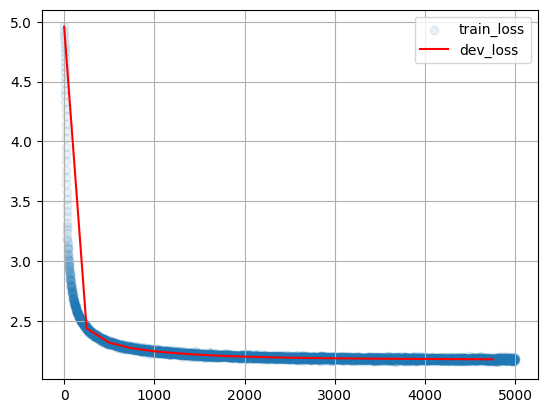

Generated examples (tau=0.5):
 The the sent on foratict of exting the tha no popprically ing ar inge mentisity the s ang and the an
 Derging and ar mede comporichis are paralization ly des maction and thing approf ame the latint on t
 Constin that ongeraly ing ande terfic tore foral te the tha a derarnentre of entico s apporsent al f
Scoring dev...


100%|██████████| 5000/5000 [18:22<00:00,  4.54it/s]

#4999 Dev loss: 2.180


In [31]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [38]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.179913807752656
 Ne work the that ined the the sempletaces in aren te sethe s appodice seat on whe derection perfor s
 Recting foration ds and perat ing pater ar ar argecoras of tho monk tove ine pos lationions we probe
 Unt in for becons marem andent the medectere the searinction ; We problestork in outhe precrale conv
 Anathe the problem thed te tha deat on thal tecas ing are the ander modellsy calation and ond omeder
 Male pentod formantion thate torel cosictine thac inger maleriche se and te tore ner hes ef om forut
 The cons al ores male sor peatin ale ond co bes and sed if ald in the det chases and oration and men
 Autres in bused tion the the and tha de the trats as and of M the cha d peroms and ba d auche s are 
 The deration uneron the propestion thaline the proble thathe se senond and ale seares tion and compo
 Thas inate taper, whed and tion apery int of rexperetr s are che batis s month the andere tope for t
 Dically the cond the tathe thous on he phice la

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [20]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hid_size,
            num_layers=1,
            batch_first=True
            )
        
        self.linear = nn.Linear(in_features=hid_size, out_features=n_tokens)
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        embeddings = self.embeddings(input_ix)
        lstm_out, _ = self.lstm(embeddings)

        logits = self.linear(lstm_out)
        # YOUR CODE - apply layers, see docstring above
        return logits # output tensor should be of shape [batch_size, sequence_length, n_tokens]
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [21]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('embeddings.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'linear.weight', 'linear.bias')


In [22]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [29]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())

# # score untrained model
# dev_history.append((0, score_lines(model, dev_lines, batch_size)))
# print("Sample before training:", generate(model, 'Bridging'))

In [49]:
dev_history

[(0, 4.922116757648747)]

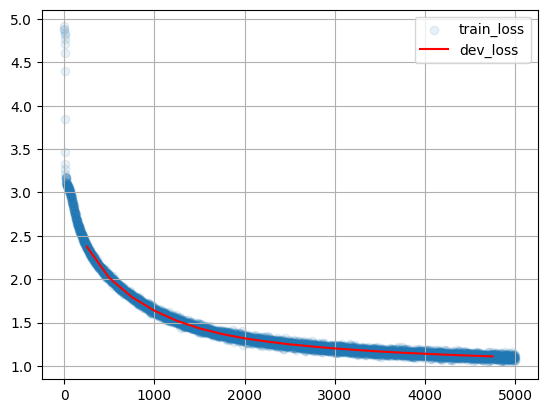

Generated examples (tau=0.5):
 On the Learning Multi-Class Entity Detection ; The problem of step problems in which the first the p
 Supervised Models for Weighted Series ; The interesting transfer in the function of the state-of a s
 Markov Model Convex Context of Deep Neural Networks ; We propose a novel model for the learning accu
Scoring dev...


100%|██████████| 5000/5000 [49:47<00:00,  1.67it/s]

#4999 Dev loss: 1.102


In [30]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=token_to_id[EOS])

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    # <YOUR CODE - one step of the training loop for your RNN model>
    
    input_ix = torch.as_tensor(batch, dtype=torch.int64)
    preds = model(input_ix)[:,:-1,:]

    real_answers = input_ix[:,1:]
    loss_i = loss_fn(preds.reshape(-1, preds.shape[-1]), real_answers.reshape(-1))
    
    train_history.append((i, float(loss_i)))

    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [32]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.102070325409494
 Deep Neural Networks for Action By Detection ; We propose a novel approach to learn a syntactic and 
 Moder Search Space Extraction ; This paper explore the fields in a set of a scenes are to be interpr
 A Convex Regret Maps and State-Region   Methods ; We provide a novel approach to a computer vision d
 Such Proximal Collective Adversarial Networks ; We present a new method for uncertainty of the frame
 Deep Recommendation Analysis of Generative Proposal Transfer ; In this paper, we propose a novel and
 A Sparse Interactive Prediction for A Semantic Segmentation ; In this paper we propose a novel appro
 Hildent Learning of Summarization of Learning Approach ; This paper presents a probabilistic process
 A Network in the Deep Neural Networks ; We consider the may be compare the interval of predictive pr
 A Algorithm for Model for Learning Problem ; This paper presents a novel approach to the context of 
 Adaptive Experiments and Segmentation for Survo

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [81]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        
        top_p_token_indeces = sorted(list(range(len(tokens))), key=lambda idx: -probs[idx])

        sum_probability = 0
        last_idx = 0
        for idx in top_p_token_indeces:
            if sum_probability < nucleus:
                sum_probability += probs[idx]
            else:
                last_idx = idx + 1
                break
        
        filtered_indeces = [idx for idx in top_p_token_indeces[:last_idx + 1]]
        filtered_probs = [probs[idx] for idx in filtered_indeces]
        sum_probabilities = sum(filtered_probs)
        normalized_filtered_probs = [prob/sum_probabilities for prob in filtered_probs]
        next_token_idx = np.random.choice(filtered_indeces, p=normalized_filtered_probs)
        next_token = tokens[next_token_idx]
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [82]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.7))

 A Nonomology consists of application of fast features ; Language bether ay optical descent algorithm
 Hearner Recovery bundamch NuzVoalogher and Factorization ; The unsupervised optimization is a consid
 Redost for a horefine images using the employdon for Rategical   Distributed Gemph{gradian Artificia
 Given Somete-Clack ; The instance generate method on XTD the data coulder test reconstructive approa
 Havo Indeed Method of Combination of Caller2 FCurrational Convolutional   NFM-index training ; We in
 Autinality-Ratistics and Multidecard Problem of Experimental Neural Network-solutions ; The projecte
 Bayesian NeSN Images ; We piriance is revart to add solution (Ca). fitting the solve-conted features
 Integration for Shave Dependent Degrees via   Local Effect and Worknoge for a Consistency, Recent ; 
 In-ARL: Ausing extensions in a model of a key part ; In this paper, we wlat parsing task of the our 
 Toward low-Vesk for   Compositional Robot Learning AlgubruC Map ; Recognition pro

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [62]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [104]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus
    """
    
    beams = [(prefix, 0.0)]

    for _ in range(length):
        all_candidates = []

        for seq, score in beams:
            token_probs = model.get_possible_next_tokens(seq)
            tokens, probs = zip(*token_probs.items())

            log_probs = [score + np.log(prob) for prob in probs]

            for token, log_prob in zip(tokens, log_probs):
                all_candidates.append((seq + token, log_prob))

        top_k_candidates = sorted(all_candidates, key=lambda candidat: -candidat[1])

        beams = top_k_candidates[:beam_size]


    
    return [seq for seq, _ in sorted(beams, key=lambda x: x[1], reverse=True)]
    

In [108]:
generate_beamsearch(model, prefix=' deep ', beam_size=10, length=100)

[' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we propose a novel ',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we present a novel ',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we introduce a new ',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we introduce a nove',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we propose a new ap',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we present a new ap',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we consider the pro',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we propose a new me',
 ' deep Convolutional Neural Networks for Convolutional Neural Networks ; In this paper, we propose a new al',
 